# NN Train on MNIST digits

## import MNIST TRAINING 28x28 digits
CSV file each row is <category><pixels 0..783>

In [29]:
DATA_DIR = '../../Data/mnist/' # contains mnist_train.csv file

In [30]:
import math
import random
import numpy as np
import time

%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [31]:
def load_mnist():
    print('Loading MNIST training data...')
    file_data = np.loadtxt(DATA_DIR+'mnist_train.csv', delimiter = ',')
    print('Loaded MNIST training data, shape {0} dtype {1}'.format(file_data.shape, file_data.dtype))
    # extract first element (label) from each row of the data, and convert to one-hot 0..9
    labels = file_data[:,0].astype(int) # 1st element of each row is label
    print('labels.size {0}'.format(labels.size))
    one_hot_labels = np.zeros((labels.size, 10)) # initialize same length array with 10-element zero vectors
    one_hot_labels[np.arange(labels.size),labels] = 1 # set the n'th element of one-hot vector to 1 (n=label)
    # extract the digit pixels
    digits = file_data[:,1:] # remaining elements are 784-pixel vectors
    digits -= digits.min() # scale the data so values are between 0 and 1
    digits /= digits.max() # scale

    return (one_hot_labels, digits)

In [32]:
(data_labels,data_digits) = load_mnist()

Loading MNIST training data...
Loaded MNIST training data, shape (60000, 785) dtype float64
labels.size 60000


### Inspect the first digit
Categorized as '5', i.e. categories[0] = 5
digits[0] is a 784-element vector representing the 28x28 grayscale image

In [33]:
data_labels[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [34]:
print(data_labels.shape,data_labels.size)
print(data_digits.shape)

(60000, 10) 600000
(60000, 784)


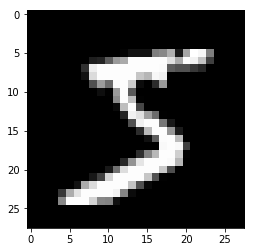

In [35]:
def print_digit(digit):
    test_digit = np.mat(digit).reshape(28,28)
    plt.imshow(test_digit, cmap='gray')
    plt.show()
    
print_digit(data_digits[0])

# Tensorflow

In [36]:
import tensorflow as tf

sess = tf.InteractiveSession()

x1 = tf.constant([1,2,3,4])
x2 = tf.constant([5,6,7,8])
result = tf.multiply(x1,x2)
print(sess.run(result))
sess.close()

[ 5 12 21 32]


Print the max and min values of the pixels in all the digits

In [37]:
data_digits.max()

1.0

In [38]:
data_digits.min()

0.0

## Define the CNN

We start by defining input layer n x 784, and a labels layer n x 10

In [39]:
IMAGE_SIZE_X = 28
IMAGE_SIZE_Y = 28
IMAGE_SIZE = IMAGE_SIZE_X * IMAGE_SIZE_Y
LABELS_SIZE = 10

layer_input = tf.placeholder(tf.float32, [None, IMAGE_SIZE])

layer_labels = tf.placeholder(tf.float32, [None, LABELS_SIZE])

Create next input layer by reshaping 1x784 input into 28x28

In [40]:
layer_input2d = tf.reshape(layer_input, [-1,IMAGE_SIZE_X,IMAGE_SIZE_Y,1])

Define convolution layer 5x5x32, i.e. 32 filters, each 5x5

In [41]:
layer_conv1 = tf.layers.conv2d(inputs=layer_input2d, filters=32, kernel_size=[5, 5], padding="same", activation=tf.nn.relu)

Define max pooling layer 2x2

In [42]:
layer_pool1 = tf.layers.max_pooling2d(inputs=layer_conv1, pool_size=[2, 2], strides=2)

Flatten maxpool output

In [43]:
#layer_pool_flat = tf.reshape(layer_pool1, [-1, 14 * 14 * 32])
layer_pool_flat = tf.layers.flatten(layer_pool1)

Define hidden layer 1x1024

In [44]:
layer_hidden = tf.layers.dense(inputs=layer_pool_flat, units=1024, activation=tf.nn.relu)

Define output layer for categories 1x10

In [45]:
layer_output = tf.layers.dense(inputs=layer_hidden, units=LABELS_SIZE)

Define loss function as softmax cross-entropy between output and training labels

In [46]:
loss = tf.losses.softmax_cross_entropy(layer_labels, layer_output)

Define backpropagation training step

In [47]:
train_step = tf.train.AdamOptimizer(1e-3).minimize(loss)

Define accuracy metric:

    a prediction is 'correct' if the output category is the same as the label category,
    
    i.e. the output and labels are expressed as a 1x10 vector of values 0..1 where the index of the highest (max) value represents the category
    
    Accuracy (for our purposes) is the proportion (0..1) of the results that are 'correct'. 
    We calculate this value by scoring a correct result as '1' and an incorrect result as '0', 
    and computing the arithmetic mean of all the values. Hence '0,1,0,1,1' gives mean (and our accuracy) of 0.6.

In [48]:
correct_prediction = tf.equal(tf.argmax(layer_output, 1), tf.argmax(layer_labels, 1))

In [49]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## OK, let's create a session and run this model...

In [50]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

STEP_SIZE = 12345
STEPS_COUNT = 3
(DATA_COUNT,_) = data_digits.shape

step_cursor = 0

# record start time
START_TIME = time.process_time()

# create lists to hold time, accuracy tuples
graph_data_time = [0]     # initialize with x=0, y=0 for first point
graph_data_accuracy = [0]

print('Starting training, {0} steps of {1} images'.format(STEPS_COUNT,STEP_SIZE))

for i in range(STEPS_COUNT):
    # update cursor to select current 'step' of training data
    step_cursor += STEP_SIZE # index into data_digits and data_labels for current step
    step_limit = step_cursor + STEP_SIZE # limit index for end of batch
    if step_limit > DATA_COUNT:
        step_cursor = step_limit - DATA_COUNT # wrap around to start of data
        step_limit = STEP_SIZE
    
    # create input digits step_digits and asociated labels step_labels
    step_digits = data_digits[step_cursor:step_limit]
    step_labels = data_labels[step_cursor:step_limit]

    # create tensorflow 'feed dictionary' that maps inputs to tensorflow tensors
    feed_dict={layer_input: step_digits, layer_labels: step_labels}
    
    # do training run for this step
    train_step.run(feed_dict=feed_dict)
    
    # calculate accuracy
    train_accuracy = accuracy.eval(feed_dict=feed_dict)
    
    # note process time for this step in ns
    execution_time_ns = time.process_time() - START_TIME
    
    graph_data_time.append(execution_time_ns)
    graph_data_accuracy.append(train_accuracy)
    
    print('step {0:3d} digits {1:5d}..{2:5d} accuracy {3:.3f}'.format(i,step_cursor, step_limit, train_accuracy))
    
kernel = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'layer_conv1/kernel')

print('Run complete')
sess.close()

Starting training, 3 steps of 12345 images
step   0 digits 12345..24690 accuracy 0.672
step   1 digits 24690..37035 accuracy 0.804
step   2 digits 37035..49380 accuracy 0.813
Run complete


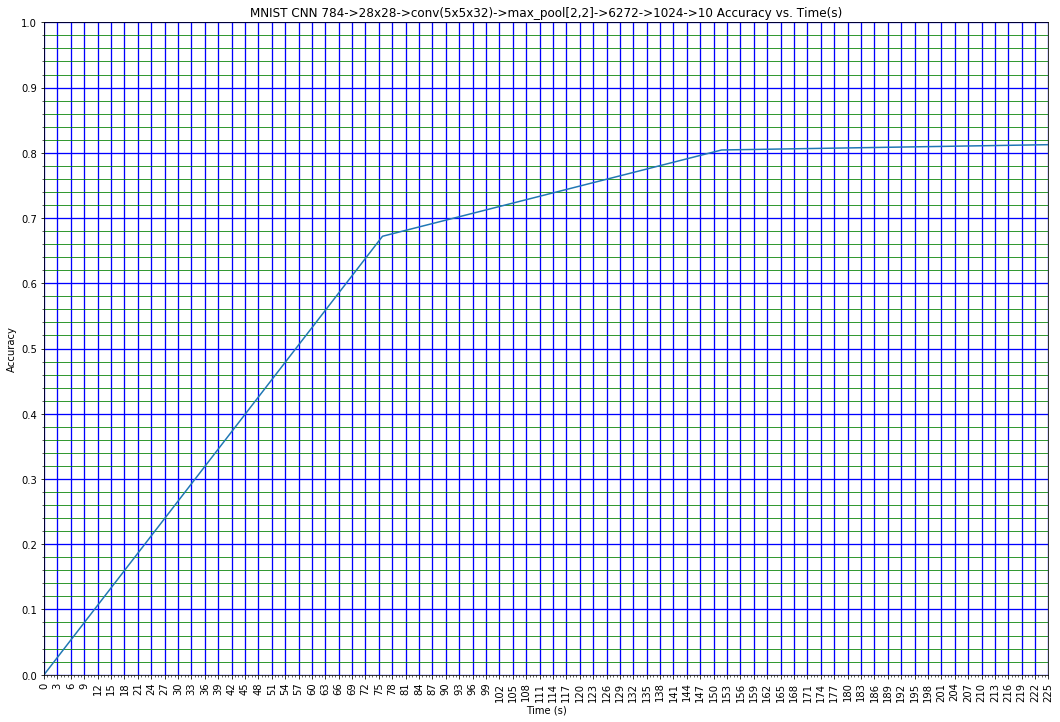

In [51]:
from matplotlib.ticker import MultipleLocator

fig = plt.figure(figsize=(18,12))
ax = fig.add_subplot(1, 1, 1)

ax.set_title("MNIST CNN 784->28x28->conv(5x5x32)->max_pool[2,2]->6272->1024->10 Accuracy vs. Time(s)", fontsize='large')

## Set up Time x axis

ax.set_xlabel("Time (s)")
# Min x axis value is 0 (so y-axis crosses at x=0)
ax.set_xlim(left=0)
# x ticks at 10s
ax.set_xticks(np.arange(0.0,max(graph_data_time),STEPS_COUNT))
ax.xaxis.grid(which='major', color='b', linewidth=1.3)

## Set up Accuracy y axis

ax.set_ylabel("Accuracy")
ax.set_ylim(bottom=0)
# Set Accuracy tick locations and define horizontal grid lines
minorLocator = MultipleLocator(0.05)
majorLocator = MultipleLocator(0.1)
ax.yaxis.set_minor_locator(minorLocator)
ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.grid(which='major', color='b', linewidth=1.3)
ax.yaxis.grid(which='minor', color='g')

# Plot the chart
ax.plot(graph_data_time, graph_data_accuracy)

plt.minorticks_on()
plt.xticks(rotation=90)
plt.show(fig)